## Eurofab model training

In [15]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from core.utils import used_keys

from palettable.colorbrewer.qualitative import Set3_12
from sklearn.metrics import davies_bouldin_score, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn import model_selection
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer

from core.generate_predictions import read_train_test, get_cluster_names, get_level_cut

In [2]:
v = 'v3'

sample_size = 600_000

mapping_level = 4

train_test_iteration = 7

In [3]:
%%time
X_resampled, y_resampled = read_train_test(train_test_iteration, mapping_level, sample_size)


from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier(random_state=123, verbose=1,
                                            learning_rate = 0.03,
                                            max_depth = None, 
                                            max_iter = 120, 
                                            max_leaf_nodes=None,
                                            max_features=.5
                                           )
model.fit(X_resampled, y_resampled)
print(model.score(X_resampled, y_resampled))

final_without_noise
6     600000
1     600000
7     600000
8     600000
14    600000
2     600000
15    600000
13    600000
5     600000
16    600000
9     600000
12    600000
11    600000
Name: count, dtype: int64
Binning 8.087 GB of training data: 3.625 s
Binning 0.899 GB of validation data: 0.393 s
Fitting gradient boosted rounds:
[1/120] 13 trees, 893629 leaves (68740 on avg), max depth = 59, train loss: 2.32222, val loss: 2.36821, in 129.254s
[2/120] 13 trees, 3523422 leaves (271032 on avg), max depth = 157, train loss: 2.13320, val loss: 2.21806, in 366.993s
[3/120] 13 trees, 3553717 leaves (273362 on avg), max depth = 152, train loss: 1.97650, val loss: 2.09519, in 373.911s
[4/120] 13 trees, 3552116 leaves (273239 on avg), max depth = 176, train loss: 1.84211, val loss: 1.99092, in 377.135s
[5/120] 13 trees, 3548134 leaves (272933 on avg), max depth = 151, train loss: 1.72445, val loss: 1.90045, in 376.539s
[6/120] 13 trees, 3547731 leaves (272902 on avg), max depth = 164, train

In [4]:
%%time
from pickle import dump
with open(f"../data/model_{mapping_level}_{train_test_iteration}.pkl", "wb") as f:
    dump(model, f, protocol=5)

CPU times: user 44.9 ms, sys: 11.9 s, total: 11.9 s
Wall time: 12.6 s


In [5]:
coredir = '/data/uscuni-eurofab-overture/'

In [6]:
level_cut = get_level_cut(mapping_level)
X_test = pd.read_parquet(f'{coredir}processed_data/train_test_data/testing_data{train_test_iteration}.pq')
y_test = pd.read_parquet(f'{coredir}processed_data/train_test_data/testing_labels{train_test_iteration}.pq')
y_test['final_without_noise'] = y_test['final_without_noise'].map(level_cut.to_dict())

cluster_names = get_cluster_names(mapping_level)

assert y_test.final_without_noise.isna().sum() == 0
assert (X_test.index == y_test.index).all()

print(y_test.final_without_noise.map(cluster_names).value_counts())

if 'source' in X_test.columns:
    # we can do this because of random forest splitting
    factorizer_dict = pd.Series(np.arange(len(source_factorizer[1])), source_factorizer[1].values, ).to_dict()
    X_test['source'] = X_test['source'].map(factorizer_dict)

## predictions
predictions = model.predict(X_test)

weighted = f1_score(y_test, predictions, average='weighted')
micro = f1_score(y_test, predictions, average='micro')
macro = f1_score(y_test, predictions, average='macro')
overall_acc = pd.Series([weighted, micro, macro], index=['Weighted F1', 'Micro F1', 'Macro F1'])

f1s_vals = f1_score(y_test, predictions, average=None)
f1s = pd.Series(
    f1s_vals,
    index = [cluster_names[k] for k in sorted(np.unique(predictions))]
)
f1s = f1s.sort_values()

final_without_noise
Aligned Winding Streets               1911488
Sparse Open Layout                    1901302
Dense Connected Developments          1843043
Compact Development                   1646066
Sparse Road-Linked Development        1377693
Cul-de-Sac Layout                     1362516
Dense Standalone Buildings            1073182
Sparse Rural Development               643288
Linear Development                     464712
Large Interconnected Blocks            218424
Extensive Wide-Spaced Developments     186941
Large Utilitarian Development          178777
Dispersed Linear Development           167466
Name: count, dtype: int64


In [7]:
overall_acc

Weighted F1    0.545135
Micro F1       0.543666
Macro F1       0.542424
dtype: float64

In [15]:
f1s.sort_index()

Aligned Winding Streets               0.455454
Compact Development                   0.548607
Cul-de-Sac Layout                     0.512535
Dense Connected Developments          0.584578
Dense Standalone Buildings            0.565387
Dispersed Linear Development          0.649112
Extensive Wide-Spaced Developments    0.363151
Large Interconnected Blocks           0.601881
Large Utilitarian Development         0.435066
Linear Development                    0.528131
Sparse Open Layout                    0.607502
Sparse Road-Linked Development        0.488297
Sparse Rural Development              0.711807
dtype: float64

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [298]:
labels = ['Dense Connected Developments',
 'Large Interconnected Blocks',
 'Dense Standalone Buildings',
 'Compact Development',
 'Cul-de-Sac Layout',
 'Aligned Winding Streets',
 'Sparse Rural Development',
 'Dispersed Linear Development',
 'Linear Development',
 'Sparse Open Layout',
 'Sparse Road-Linked Development',
 'Large Utilitarian Development',
 'Extensive Wide-Spaced Developments']

In [18]:
cm = confusion_matrix(y_test.final_without_noise.map(cluster_names), 
                      pd.Series(predictions).map(cluster_names), 
                      labels=labels,
                      normalize='true'
                     )

In [19]:
# ## testing sklearn categorical ordering
# cm_vals = cm.sum(axis=0)
# pd.testing.assert_series_equal(
#     pd.Series(cm_vals, index = sorted(np.unique(mapped_predictions))).sort_values(ascending=False), 
#     pd.Series(mapped_predictions).value_counts(), check_names=False)

# cm_vals = cm.sum(axis=1)
# pd.testing.assert_series_equal(
#     pd.Series(cm_vals, index = sorted(np.unique(mapped_predictions))).sort_values(ascending=False), 
#     y_test.final_without_noise.value_counts(), check_names=False)

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, decimals=2), 
                              display_labels=labels
                             )

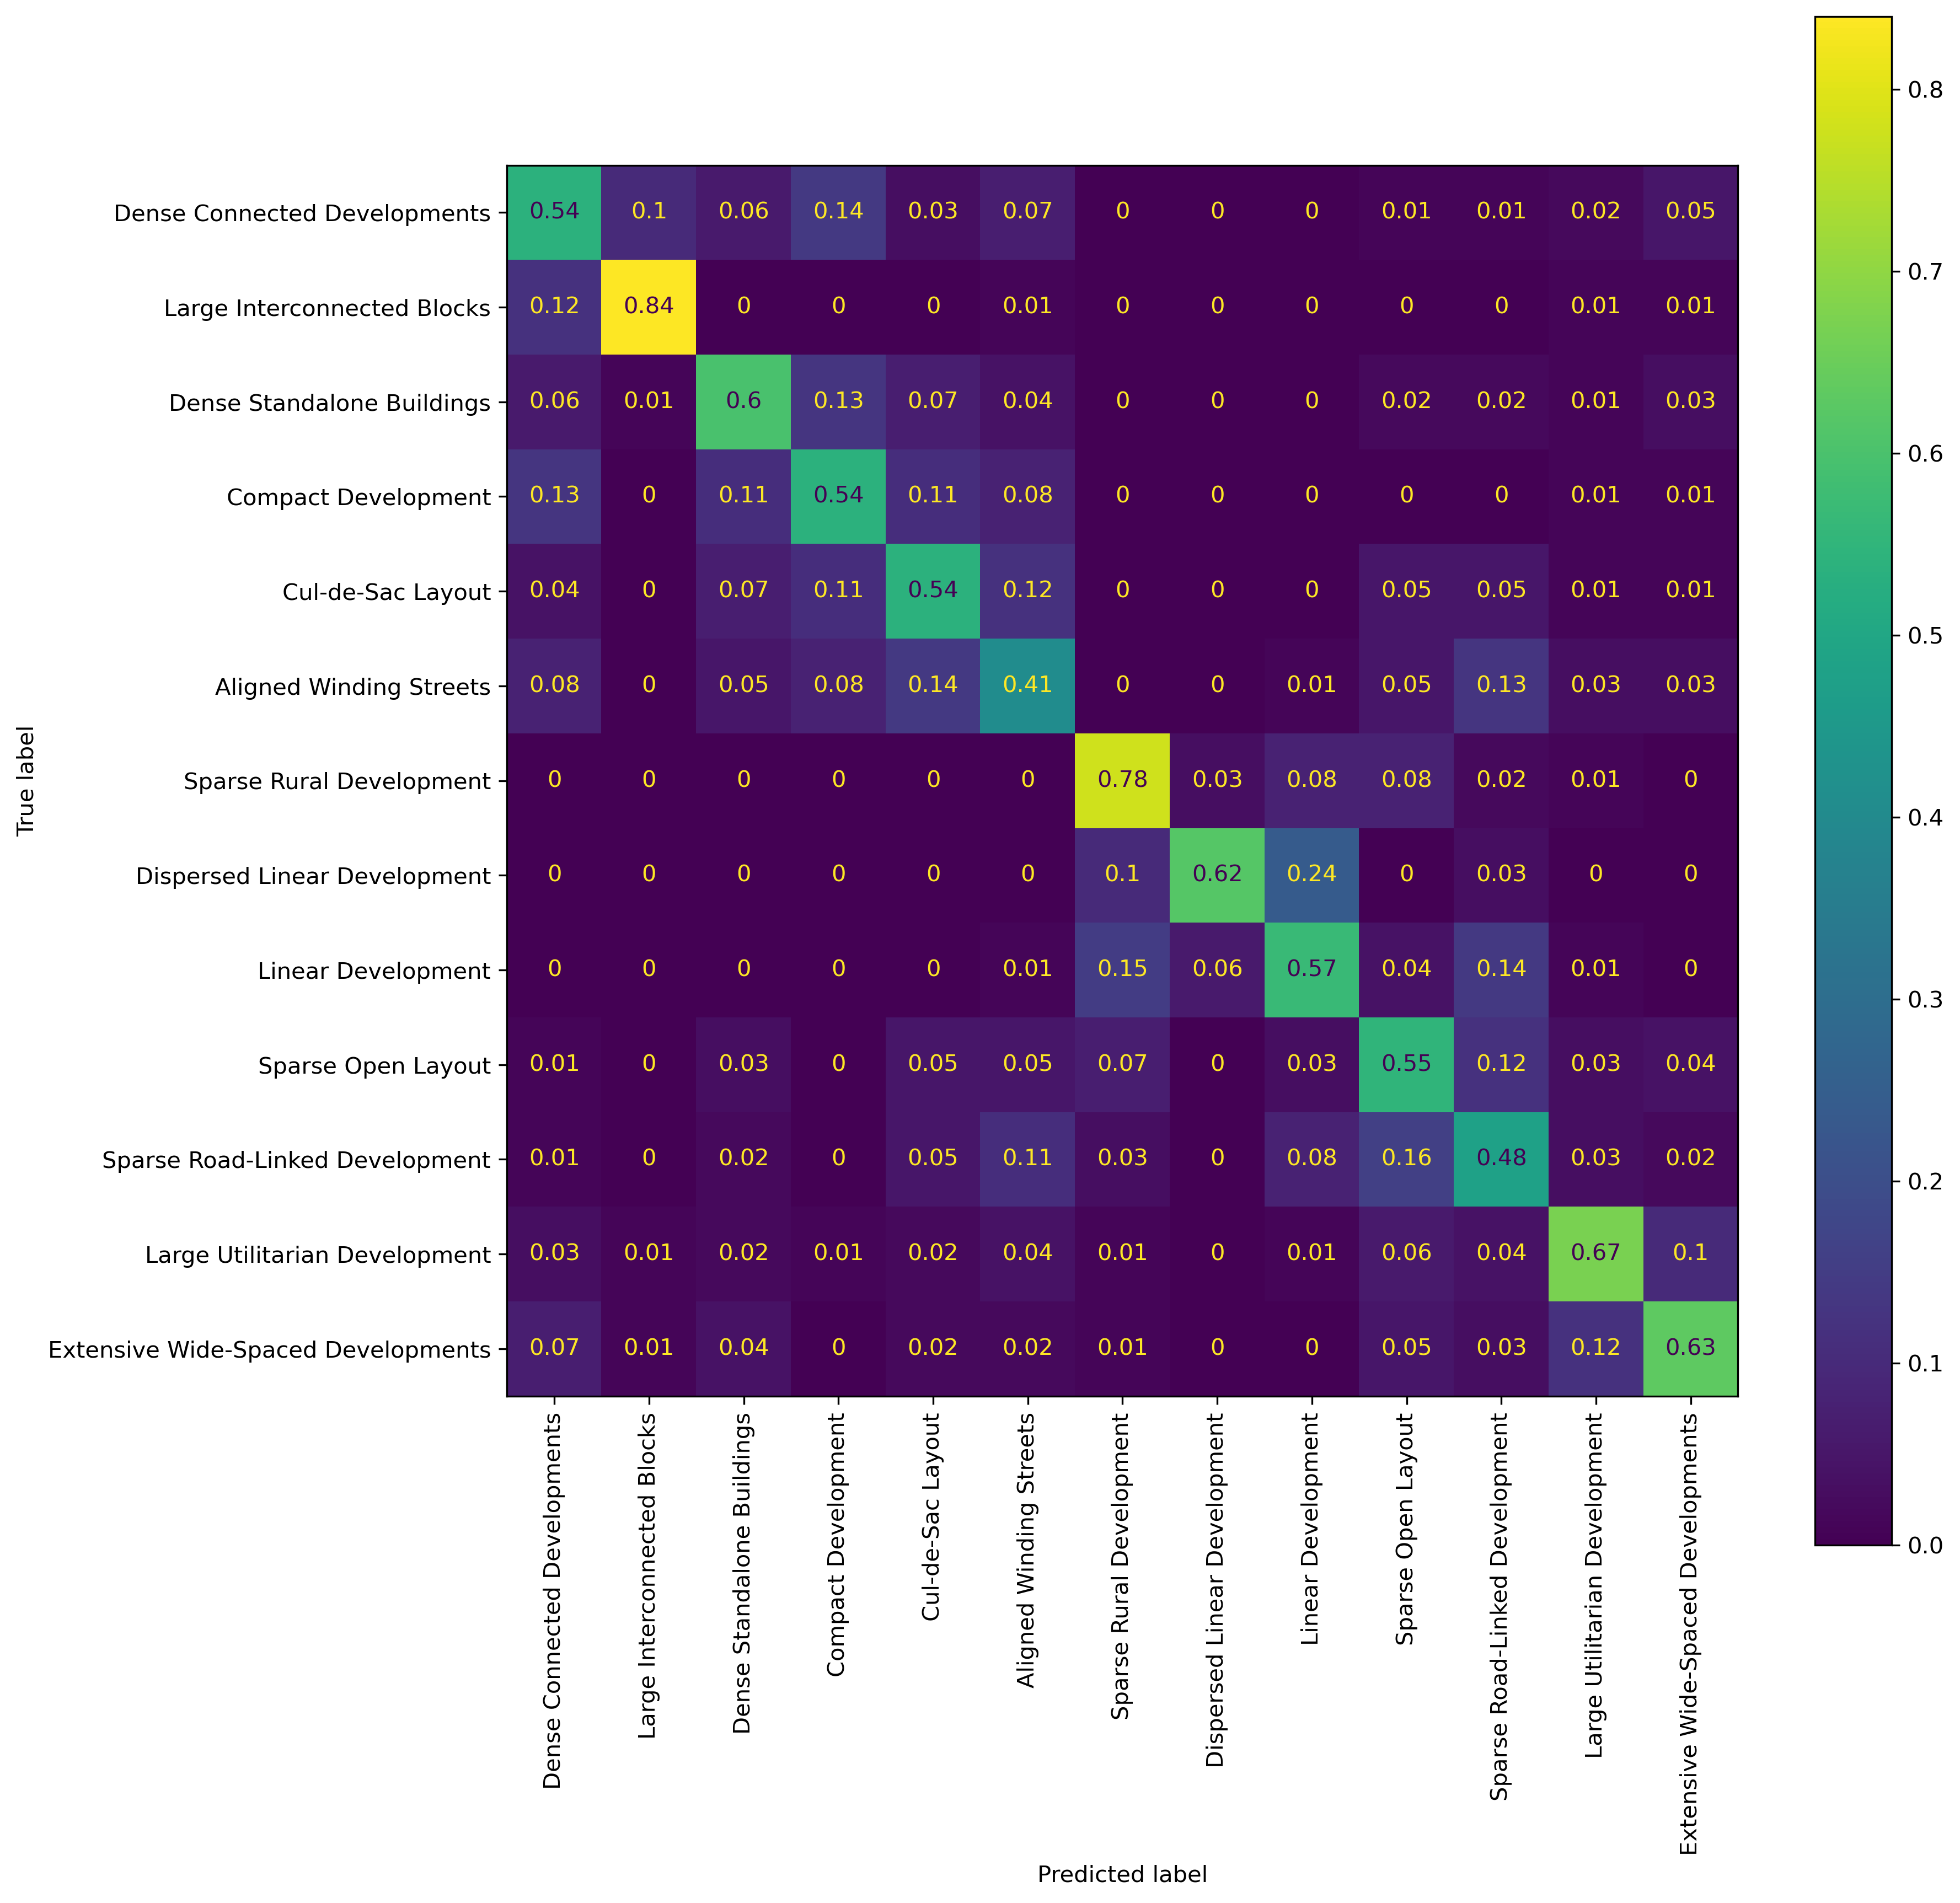

In [32]:
fig,ax = plt.subplots(figsize=(12,12), dpi=300)
disp.plot( xticks_rotation = 'vertical', ax=ax)

1. First cluster problem has to do with Czech preprocessing of the core dataset.

### Plot predictions

In [16]:
import pickle
from lonboard import SolidPolygonLayer, Map
from lonboard.basemap import CartoBasemap
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12
from core.cluster_validation import get_color
from core.utils import combine_regions_data
from core.generate_predictions import read_train_test, get_cluster_names, get_level_cut

In [17]:
# regions_datadir = "/data/uscuni-eurofab-overture/"
# region_hulls = gpd.read_parquet(
#         regions_datadir + "regions/" + "ov_ce_region_hulls.parquet"
#     )
# region_hulls.explore()

In [25]:
coredir = '/data/uscuni-eurofab-overture/'
mapping_level = 4
train_test_iteration = 7


In [18]:
with open(f'../data/model_{mapping_level}_{train_test_iteration}.pkl', 'rb') as f:
    model = pickle.load(f)

In [26]:
level_cut = get_level_cut(mapping_level)
y_test = pd.read_parquet(f'{coredir}processed_data/train_test_data/testing_labels{train_test_iteration}.pq')
y_test['final_without_noise'] = y_test['final_without_noise'].map(level_cut.to_dict())

cluster_names = get_cluster_names(mapping_level)


In [33]:
def get_buildings_and_predictions(region_id):
    ## generate the data for the predictions and index the test data
    all_data, all_labels, _ = combine_regions_data([region_id], char_type='only_unweighted_lag_overture')
    predicted_index = all_data.index.str.split('_').str[-1].astype(int)
    region_test_labels = all_labels.index.isin(y_test.index)
    
    
    # predict the whole region
    regional_predictions = model.predict(all_data)
    # map the original predictions and whether the test cases are accurate
    region_test_labels = y_test.index.isin(all_labels.index)
    # accurate = predictions[region_test_labels] == y_test[region_test_labels].final_without_noise
    # accurate.index = accurate.index.str.split('_').str[-1].astype(int)
    
    
    # read the building polygons and assign the new predictions
    buildings = gpd.read_parquet(f'/data/uscuni-eurofab-overture/processed_data/buildings/buildings_{region_id}.parquet')
    buildings = buildings.loc[predicted_index]
    buildings['prediction'] = regional_predictions.astype(int)
    buildings['in_testset'] = all_labels.index.isin(y_test.index)
    # buildings['accurate'] = accurate
    return buildings

In [34]:
%%time
vienna_buildings = get_buildings_and_predictions(84568)
brno_buildings = get_buildings_and_predictions(90996)
munich_buildings = get_buildings_and_predictions(36769)
wroclaw_buildings = get_buildings_and_predictions(91484)

CPU times: user 17min 25s, sys: 11 s, total: 17min 36s
Wall time: 1min 53s


In [35]:
import shapely
import contextily as cx

from matplotlib.colors import to_hex
from matplotlib import colormaps
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches

In [36]:
cmap = [to_hex(c) for c in colormaps.get_cmap('tab20b').colors]

In [41]:
def plot_predictions(buildings, ax,  cmap, name=''):
    
    buildings_centre = shapely.box(*shapely.Point(buildings.centroid.x.mean(), buildings.centroid.y.mean()).buffer(10_000).bounds)
    to_plot = buildings[buildings.intersects(buildings_centre)]

    for cluster in to_plot.prediction.unique():
        to_plot[to_plot.prediction == cluster].plot(ax=ax, color=cmap[cluster])
    
    ax.set_axis_off()
    ax.set_title(name)
    
    cx.add_basemap(ax, crs=buildings.crs, source=cx.providers.CartoDB.PositronNoLabels)
    ax.add_artist(ScaleBar(1, location="upper right"))

    return ax

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16,16), dpi=300)

h1 = plot_predictions(vienna_buildings, ax[0][0], cmap, 'Vienna')
h2 = plot_predictions(munich_buildings, ax[0][1], cmap, 'Munich')
h3 = plot_predictions(wroclaw_buildings, ax[1][0], cmap, 'Wroclaw')
h4 = plot_predictions(brno_buildings, ax[1][1], cmap, 'Brno')

legend_patches = [mpatches.Patch(color=cmap[cluster], label=cluster_names[str(cluster)]) for cluster in range(1, 17)]
fig.legend(handles=legend_patches, loc='lower right')

In [225]:
plot_buildings = wroclaw_buildings

In [226]:
layer = SolidPolygonLayer.from_geopandas(
    gdf=plot_buildings, opacity=0.15
)

/home/krasen/morphometrics/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [227]:
np.unique(plot_buildings['prediction'].values.astype(int))

array([ 1,  2,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16])

In [228]:
m = Map(layer, basemap_style=CartoBasemap.DarkMatter)

In [229]:
from sidecar import Sidecar
sc = Sidecar(title='buildings')
with sc:
    display(m)

In [230]:
final_colors = get_color(np.arange(0, 20))

In [231]:
layer.get_fill_color = final_colors[plot_buildings['prediction'].astype(int)]

In [171]:
layer.get_fill_color = final_colors[plot_buildings['accurate'].astype(int)]